In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! pip install keras-tuner

In [ ]:
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cbook as cbook
import tensorflow as tf
import kerastuner as kt
from tensorflow.keras.losses import MeanAbsoluteError
import keras
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
path = r'/content/gdrive/MyDrive/transformed' # use your path
bus_all_files = glob.glob(path + "/bus/*.csv")
car_all_files = glob.glob(path + "/car/*.csv")
pedestrian_all_files = glob.glob(path + "/pedestrian/*.csv")
static_all_files = glob.glob(path + "/static/*.csv")
train_all_files = glob.glob(path + "/train/*.csv")  

In [ ]:
all_files_train=[]
all_files_test=[]

# Session Split

In [ ]:
bus_all_files.sort()
all_files_train = all_files_train + bus_all_files[:-5]
all_files_test = all_files_test + bus_all_files[-5:]

car_all_files.sort()
all_files_train = all_files_train + car_all_files[:-5]
all_files_test = all_files_test + car_all_files[-5:]

pedestrian_all_files.sort()
all_files_train = all_files_train + pedestrian_all_files[:-5]
all_files_test = all_files_test + pedestrian_all_files[-5:]

static_all_files.sort()
all_files_train = all_files_train + static_all_files[:-5]
all_files_test = all_files_test + static_all_files[-5:]

train_all_files.sort()
all_files_train = all_files_train + train_all_files[:-5]
all_files_test = all_files_test + train_all_files[-5:]

In [ ]:
# Train Dataset
li_train = []
for filename in all_files_train:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_train.append(df)
frame_train = pd.concat(li_train, axis=0, ignore_index=True)
frame_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,7,7,10,7,7,0,0,310,3,3,...,7.0,7.0,10.0,10.0,0,0,14,7,7,1769
1,7,7,7,10,7,0,0,0,310,3,...,8.0,7.0,7.0,10.0,0,0,0,14,7,2272
2,7,7,7,7,10,0,0,0,0,310,...,8.0,8.0,7.0,7.0,0,0,0,0,14,2549
3,9,7,7,7,7,1757,0,0,0,0,...,10.0,8.0,8.0,7.0,68,0,0,0,0,2674
4,9,9,7,7,7,4216,1757,0,0,0,...,10.0,10.0,8.0,8.0,151,68,0,0,0,2393


In [ ]:
frame_train.shape

(307143, 46)

In [ ]:
# Test Dataset
li_test = []
for filename in all_files_test:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_test.append(df)
frame_test = pd.concat(li_test, axis=0, ignore_index=True)
frame_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,12,11,12,11,11,46905,54253,63379,68557,68557,...,18.0,14.0,14.0,14.0,756,956,972,1026,1026,51399
1,10,12,11,12,11,52184,46905,54253,63379,68557,...,18.0,18.0,14.0,14.0,908,756,956,972,1026,49728
2,12,10,12,11,12,57262,52184,46905,54253,63379,...,16.0,18.0,18.0,14.0,828,908,756,956,972,46853
3,12,12,10,12,11,53862,57262,52184,46905,54253,...,16.0,16.0,18.0,18.0,894,828,908,756,956,43102
4,10,12,12,10,12,57407,53862,57262,52184,46905,...,16.0,16.0,16.0,18.0,1265,894,828,908,756,40899


In [ ]:
frame_test.shape

(15556, 46)

# Dealing with Nan Values

In [ ]:
frame_train.replace('-', np.NaN, inplace = True)
frame_train.isna().sum().sum()

frame_test.replace('-', np.NaN, inplace = True)
frame_test.isna().sum().sum()

267532

In [ ]:
imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
imputed_dataset = imputer.fit_transform(frame_train)
frame_train = pd.DataFrame(imputed_dataset,columns = frame_train.columns)
frame_train.isna().sum().sum()



imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
imputed_dataset = imputer.fit_transform(frame_test)
frame_test = pd.DataFrame(imputed_dataset,columns = frame_test.columns)
frame_test.isna().sum().sum()

0

In [ ]:
frame_train.describe()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
count,307143.000000,307143.000000,307143.000000,307143.000000,307143.000000,307143.000000,307143.000000,307143.000000,307143.000000,307143.000000,...,307143.000000,307143.000000,307143.000000,307143.000000,307143.000000,307143.000000,307143.000000,307143.000000,307143.000000,307143.000000
mean,7.624627,7.589022,7.607970,7.595837,7.608090,9591.825961,9594.298871,9596.322355,9598.814064,9601.109145,...,5.795447,5.581005,5.636221,5.733294,166.575953,166.609202,166.637605,166.670157,166.705141,9583.957140
std,2.549231,2.555591,2.551725,2.555201,2.553546,12934.223836,12939.185761,12942.477167,12946.737382,12950.919244,...,6.740206,6.695443,6.705898,6.734922,201.875580,201.941083,201.984082,202.035543,202.093875,12489.842433
min,-0.568271,1.000000,1.000000,1.000000,0.736304,0.000000,0.000000,0.000000,0.000000,0.000000,...,-30.000000,-30.000000,-30.000000,-30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.883555,6.869206,6.938935,6.888668,6.880666,1163.000000,1163.000000,1163.000000,1163.000000,1163.000000,...,2.000000,2.000000,2.000000,2.000000,27.000000,27.000000,27.000000,27.000000,27.000000,1368.000000
50%,7.088346,7.000000,7.039853,7.003631,7.045025,4596.000000,4596.000000,4596.000000,4596.000000,4596.000000,...,7.224910,6.634919,6.761177,6.962602,93.000000,93.000000,93.000000,93.000000,93.000000,4808.000000
75%,9.000000,9.000000,9.000000,9.000000,9.000000,12951.000000,12951.000000,12951.000000,12951.000000,12959.500000,...,7.751079,7.110980,7.339311,7.850904,240.000000,240.000000,240.000000,240.000000,240.000000,13071.000000
max,15.000000,15.000000,15.000000,15.000000,15.000000,173016.000000,173016.000000,173016.000000,173016.000000,173016.000000,...,33.000000,33.000000,33.000000,33.559337,4178.000000,4178.000000,4178.000000,4178.000000,4178.000000,161878.000000


In [ ]:
frame_train.isna().sum().sum()

0

In [ ]:
frame_test.isna().sum().sum()

0

In [ ]:
# LOW - below 1000
# MEDIUM - between 1000 and 4000
# HIGH - greater than 4000

In [ ]:
frame_low_train = frame_train[frame_train['DL_bitrate']<=1000]
frame_medium_train = frame_train[(frame_train['DL_bitrate']>1000) & (frame_train['DL_bitrate']<=4000)]
frame_high_train = frame_train[frame_train['DL_bitrate']>4000]

In [ ]:
frame_low_test = frame_test[frame_test['DL_bitrate']<=1000]
frame_medium_test = frame_test[(frame_test['DL_bitrate']>1000) & (frame_test['DL_bitrate']<=4000)]
frame_high_test = frame_test[frame_test['DL_bitrate']>4000]

In [ ]:
col_names_scaled =['CQI-0', 'CQI-1', 'CQI-2', 'CQI-3', 'CQI-4', 'DL_bitrate-0',
       'DL_bitrate-1', 'DL_bitrate-2', 'DL_bitrate-3', 'DL_bitrate-4', 'SNR-0', 'SNR-1', 'SNR-2', 'SNR-3', 'SNR-4', 'DL_bitrate']

## Low Throughput

In [ ]:
frame_low_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
16,9.0,9.0,9.0,7.0,7.0,1543.0,2337.0,2874.0,2169.0,3824.0,...,9.0,9.0,8.0,8.0,30.0,46.0,54.0,78.0,75.0,769.0
17,9.0,9.0,9.0,9.0,7.0,2169.0,1543.0,2337.0,2874.0,2169.0,...,10.0,9.0,9.0,8.0,69.0,30.0,46.0,54.0,78.0,476.0
18,9.0,9.0,9.0,9.0,9.0,156.0,2169.0,1543.0,2337.0,2874.0,...,10.0,10.0,9.0,9.0,5.0,69.0,30.0,46.0,54.0,682.0
19,9.0,9.0,9.0,9.0,9.0,1107.0,156.0,2169.0,1543.0,2337.0,...,9.0,10.0,10.0,9.0,30.0,5.0,69.0,30.0,46.0,487.0
20,9.0,9.0,9.0,9.0,9.0,313.0,1107.0,156.0,2169.0,1543.0,...,9.0,9.0,10.0,10.0,12.0,30.0,5.0,69.0,30.0,471.0


In [ ]:
frame_low_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
813,4.0,4.0,4.0,4.0,4.0,1308.0,1789.0,1733.0,1263.0,1811.0,...,0.0,2.0,2.0,1.0,32.0,32.0,35.0,18.0,32.0,986.0
814,4.0,4.0,4.0,4.0,4.0,1252.0,1308.0,1789.0,1733.0,1263.0,...,0.0,0.0,2.0,2.0,27.0,32.0,32.0,35.0,18.0,983.0
820,4.0,4.0,4.0,4.0,4.0,2214.0,1241.0,1118.0,1118.0,671.0,...,-2.0,-2.0,-1.0,-1.0,37.0,22.0,21.0,19.0,12.0,889.0
821,4.0,4.0,4.0,4.0,4.0,1028.0,2214.0,1241.0,1118.0,1118.0,...,-2.0,-2.0,-2.0,-1.0,19.0,37.0,22.0,21.0,19.0,997.0
827,5.0,6.0,5.0,5.0,4.0,1319.0,1565.0,1040.0,1151.0,492.0,...,1.0,-4.0,-4.0,-4.0,27.0,27.0,19.0,19.0,10.0,912.0


In [ ]:
print(frame_low_train.shape)
print(frame_low_test.shape)

(63998, 46)
(1742, 46)


### With Scaling

#### MinMax Scaler

In [ ]:
df = frame_low_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (44798, 15)
Validation set shape (19200, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
26161,0.489474,0.430521,0.427088,0.417861,0.432377,0.000000,0.000000,0.000186,0.000000,0.000000,0.621509,0.596615,0.577977,0.580915,0.585663
10495,0.550368,0.214286,0.071429,0.214286,0.088595,0.014106,0.016858,0.037414,0.044226,0.000154,0.412698,0.301587,0.301587,0.317460,0.314667
43805,0.550368,0.500000,0.500000,0.500000,0.509244,0.000000,0.000000,0.007685,0.043530,0.015202,0.555556,0.555556,0.555556,0.571429,0.566400
57542,0.164968,0.071429,0.071429,0.071429,0.088595,0.000000,0.000000,0.000000,0.000000,0.000000,0.396825,0.396825,0.349206,0.349206,0.346133
54632,0.482085,0.421645,0.428353,0.427865,0.439063,0.007018,0.005619,0.017788,0.012752,0.002024,0.618181,0.592338,0.584970,0.586076,0.584864


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (44798, 15, 1)
Validation set shape (19200, 15, 1)


### Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
model_high = keras.Sequential()
model_high.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model_high.add(Dense(units=480, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=224, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=128, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(Dense(1, kernel_initializer='normal', activation='linear'))
model_high.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=mae,metrics=[mae])
model_high.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 15)                0         
                                                                 
 dense_4 (Dense)             (None, 480)               7680      
                                                                 
 dropout_3 (Dropout)         (None, 480)               0         
                                                                 
 dense_5 (Dense)             (None, 224)               107744    
                                                                 
 dropout_4 (Dropout)         (None, 224)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               28800     
                                                                 
 dropout_5 (Dropout)         (None, 128)              

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model_high.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

Epoch 1/500
1400/1400 [==============================] - 6s 4ms/step - loss: 0.1547 - mean_absolute_error: 0.1547 - val_loss: 0.1045 - val_mean_absolute_error: 0.1045
Epoch 2/500
1400/1400 [==============================] - 5s 4ms/step - loss: 0.1008 - mean_absolute_error: 0.1008 - val_loss: 0.0995 - val_mean_absolute_error: 0.0995
Epoch 3/500
1400/1400 [==============================] - 5s 4ms/step - loss: 0.0975 - mean_absolute_error: 0.0975 - val_loss: 0.0977 - val_mean_absolute_error: 0.0977
Epoch 4/500
1400/1400 [==============================] - 5s 4ms/step - loss: 0.0956 - mean_absolute_error: 0.0956 - val_loss: 0.1028 - val_mean_absolute_error: 0.1028
Epoch 5/500
1400/1400 [==============================] - 5s 4ms/step - loss: 0.0943 - mean_absolute_error: 0.0943 - val_loss: 0.1007 - val_mean_absolute_error: 0.1007
Epoch 6/500
1400/1400 [==============================] - 5s 4ms/step - loss: 0.0938 - mean_absolute_error: 0.0938 - val_loss: 0.0982 - val_mean_absolute_error: 0.098

In [ ]:
kt_train_pred_min_max_scaled = model_high.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = model_high.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.15505883594353745
Validation rmse: 0.16325242370965753


In [ ]:
df = frame_low_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.214286,0.214286,0.214286,0.214286,0.214286,0.021076,0.028024,0.027147,0.020855,0.035550,0.28125,0.28125,0.322581,0.322581,0.290323
1,0.214286,0.214286,0.214286,0.214286,0.214286,0.020174,0.020489,0.028024,0.028616,0.024792,0.28125,0.28125,0.258065,0.322581,0.322581
2,0.214286,0.214286,0.214286,0.214286,0.214286,0.035675,0.019440,0.017513,0.018461,0.013172,0.21875,0.21875,0.193548,0.225806,0.225806
3,0.214286,0.214286,0.214286,0.214286,0.214286,0.016565,0.034682,0.019440,0.018461,0.021946,0.21875,0.21875,0.193548,0.193548,0.225806
4,0.285714,0.357143,0.285714,0.285714,0.214286,0.021254,0.024515,0.016291,0.019006,0.009658,0.31250,0.31250,0.129032,0.129032,0.129032


In [ ]:
Y_test = frame_low_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_high.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

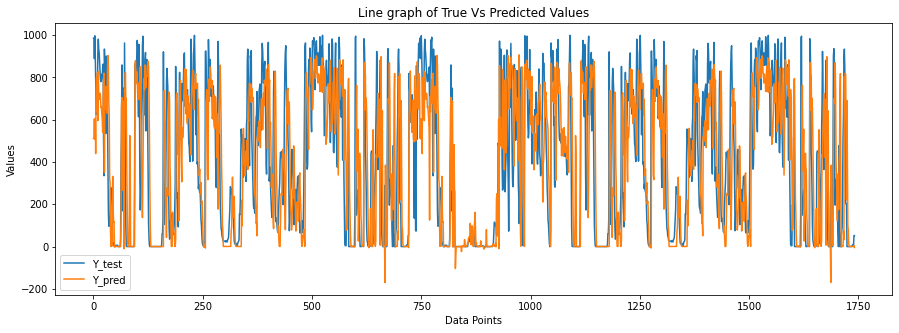

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

In [ ]:
Y_test=Y_test['DL_bitrate']

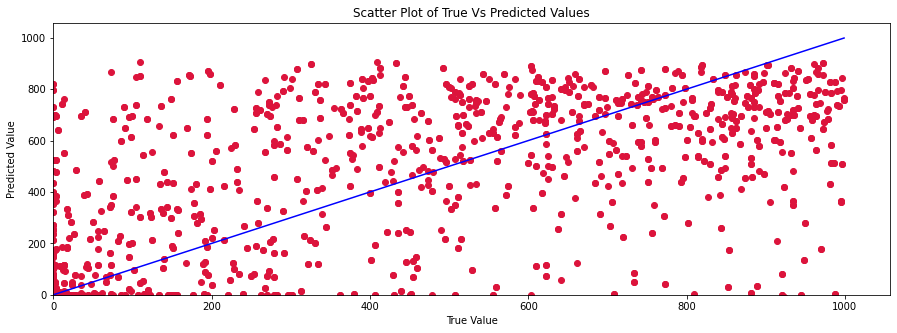

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

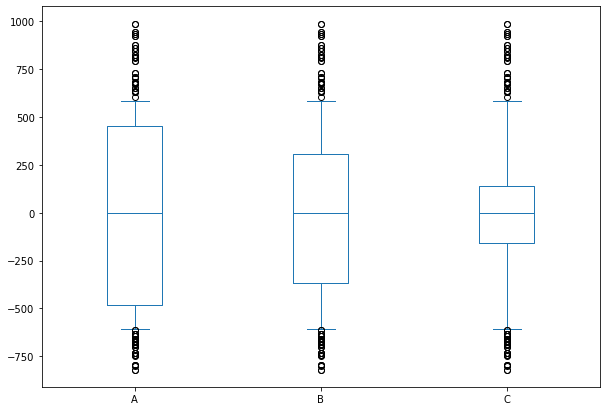

In [ ]:
a=Y_test.subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred=Y_pred[15]

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(197.6713409423828, shape=(), dtype=float64)
Decimal Representation: 197.67134094238281250000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.6810095240519157

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.7597641402609335

# Random Split

## Medium Throughput

In [ ]:
frame_medium_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,7.0,7.0,10.0,7.0,7.0,0.0,0.0,310.0,3.0,3.0,...,7.0,7.0,10.0,10.0,0.0,0.0,14.0,7.0,7.0,1769.0
1,7.0,7.0,7.0,10.0,7.0,0.0,0.0,0.0,310.0,3.0,...,8.0,7.0,7.0,10.0,0.0,0.0,0.0,14.0,7.0,2272.0
2,7.0,7.0,7.0,7.0,10.0,0.0,0.0,0.0,0.0,310.0,...,8.0,8.0,7.0,7.0,0.0,0.0,0.0,0.0,14.0,2549.0
3,9.0,7.0,7.0,7.0,7.0,1757.0,0.0,0.0,0.0,0.0,...,10.0,8.0,8.0,7.0,68.0,0.0,0.0,0.0,0.0,2674.0
4,9.0,9.0,7.0,7.0,7.0,4216.0,1757.0,0.0,0.0,0.0,...,10.0,10.0,8.0,8.0,151.0,68.0,0.0,0.0,0.0,2393.0


In [ ]:
frame_medium_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
194,8.0,6.0,6.0,6.0,10.0,19381.0,31337.0,12738.0,14740.0,24235.0,...,5.0,4.0,4.0,-3.0,278.0,404.0,215.0,238.0,303.0,3728.0
195,5.0,8.0,6.0,6.0,6.0,7012.0,19381.0,31337.0,12738.0,14740.0,...,5.0,5.0,4.0,4.0,133.0,278.0,404.0,215.0,238.0,3106.0
196,4.0,5.0,8.0,6.0,6.0,2169.0,7012.0,19381.0,31337.0,12738.0,...,2.0,5.0,5.0,4.0,37.0,133.0,278.0,404.0,215.0,3905.0
306,6.0,6.0,5.0,5.0,5.0,6598.0,6363.0,5524.0,5458.0,3836.0,...,-3.0,-4.0,-4.0,-1.0,118.0,108.0,104.0,96.0,72.0,3706.0
307,6.0,6.0,6.0,5.0,5.0,4082.0,6598.0,6363.0,5524.0,5458.0,...,-3.0,-3.0,-4.0,-4.0,70.0,118.0,108.0,104.0,96.0,3625.0


### With Scaling

#### MinMax Scaler

In [ ]:
df = frame_medium_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (53347, 15)
Validation set shape (22864, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
22355,0.500000,0.500000,0.357143,0.357143,0.357143,0.081863,0.085859,0.071683,0.046000,0.046246,0.583333,0.583333,0.600000,0.610169,0.574884
26673,0.428571,0.428571,0.357143,0.428571,0.428571,0.036914,0.034811,0.035258,0.006326,0.015173,0.600000,0.616667,0.616667,0.627119,0.607734
37973,0.418673,0.423527,0.435776,0.431426,0.426072,0.015754,0.017626,0.038002,0.029395,0.024341,0.645985,0.628478,0.616225,0.622934,0.608860
24241,0.571429,0.571429,0.571429,0.642857,0.357143,0.131733,0.147950,0.124324,0.029032,0.031318,0.616667,0.516667,0.516667,0.508475,0.492758
40176,0.429070,0.422768,0.435136,0.425852,0.431661,0.075511,0.077151,0.134173,0.047560,0.042773,0.645755,0.622035,0.614055,0.625932,0.618301


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (53347, 15, 1)
Validation set shape (22864, 15, 1)


### Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
model_high = keras.Sequential()
model_high.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model_high.add(Dense(units=320, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=256, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=64, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(Dense(1, kernel_initializer='normal', activation='linear'))
model_high.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=mae,metrics=[mae])
model_high.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 15)                0         
                                                                 
 dense_16 (Dense)            (None, 320)               5120      
                                                                 
 dropout_12 (Dropout)        (None, 320)               0         
                                                                 
 dense_17 (Dense)            (None, 256)               82176     
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 64)                16448     
                                                                 
 dropout_14 (Dropout)        (None, 64)               

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model_high.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=100)

Epoch 1/100
1668/1668 [==============================] - 7s 4ms/step - loss: 0.2164 - mean_absolute_error: 0.2164 - val_loss: 0.1868 - val_mean_absolute_error: 0.1869
Epoch 2/100
1668/1668 [==============================] - 6s 4ms/step - loss: 0.1860 - mean_absolute_error: 0.1861 - val_loss: 0.1839 - val_mean_absolute_error: 0.1840
Epoch 3/100
1668/1668 [==============================] - 6s 4ms/step - loss: 0.1847 - mean_absolute_error: 0.1847 - val_loss: 0.1844 - val_mean_absolute_error: 0.1845
Epoch 4/100
1668/1668 [==============================] - 6s 4ms/step - loss: 0.1841 - mean_absolute_error: 0.1841 - val_loss: 0.1823 - val_mean_absolute_error: 0.1824
Epoch 5/100
1668/1668 [==============================] - 7s 4ms/step - loss: 0.1836 - mean_absolute_error: 0.1836 - val_loss: 0.1835 - val_mean_absolute_error: 0.1835
Epoch 6/100
1668/1668 [==============================] - 6s 4ms/step - loss: 0.1833 - mean_absolute_error: 0.1833 - val_loss: 0.1822 - val_mean_absolute_error: 0.182

In [ ]:
kt_train_pred_min_max_scaled = model_high.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = model_high.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.21809156878967337
Validation rmse: 0.22553789760653617


In [ ]:
df = frame_medium_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.500000,0.357143,0.357143,0.357143,0.642857,0.618253,1.000000,0.406484,0.467536,0.707695,0.459459,0.485714,0.457143,0.457143,0.315789
1,0.285714,0.500000,0.357143,0.357143,0.357143,0.223683,0.618470,1.000000,0.404035,0.430428,0.378378,0.485714,0.485714,0.457143,0.500000
2,0.214286,0.285714,0.500000,0.357143,0.357143,0.069191,0.223761,0.618470,0.993973,0.371967,0.378378,0.400000,0.485714,0.485714,0.500000
3,0.357143,0.357143,0.285714,0.285714,0.285714,0.210476,0.203051,0.176277,0.173121,0.112016,0.243243,0.257143,0.228571,0.228571,0.368421
4,0.357143,0.357143,0.357143,0.285714,0.285714,0.130216,0.210550,0.203051,0.175215,0.159381,0.270270,0.257143,0.257143,0.228571,0.289474


In [ ]:
Y_test = frame_medium_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_high.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

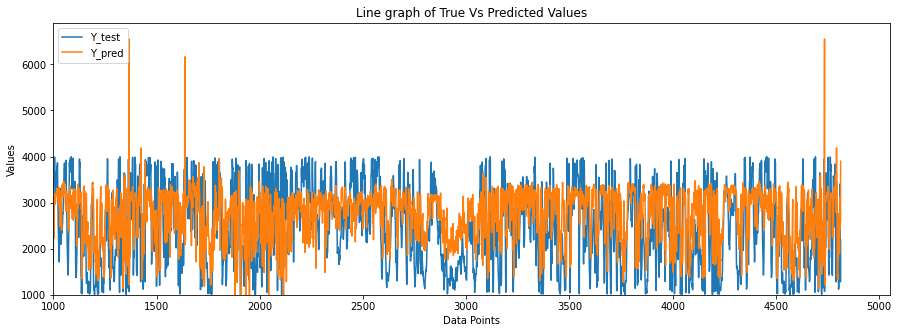

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
ax3.set(xlim=(1000, None),ylim=(1000, None))
plt.show()

In [ ]:
Y_test=Y_test['DL_bitrate']

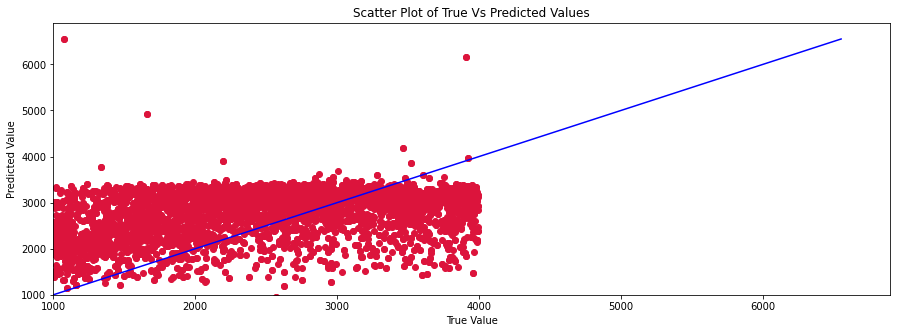

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(1000, None),ylim=(1000, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

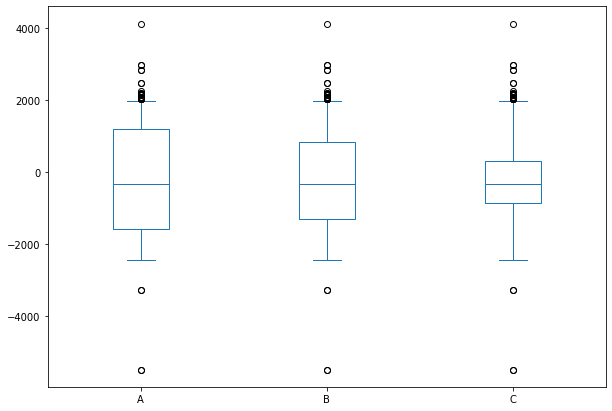

In [ ]:
a=Y_test.subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred=Y_pred[15]

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(717.6705322265625, shape=(), dtype=float64)
Decimal Representation: 717.67053222656250000000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

1.3779746372163197

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

2.1399958686436853

## High Throughput

In [ ]:
frame_high_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
247,9.0,9.0,9.0,6.0,6.0,1644.0,1308.0,1151.0,973.0,794.0,...,2.0,2.0,1.0,1.0,31.0,25.0,21.0,18.0,22.0,4515.0
248,9.0,9.0,9.0,9.0,6.0,1532.0,1644.0,1308.0,1151.0,973.0,...,4.0,2.0,2.0,1.0,29.0,31.0,25.0,21.0,18.0,5540.0
249,9.0,9.0,9.0,9.0,9.0,3836.0,1532.0,1644.0,1308.0,1151.0,...,4.0,4.0,2.0,2.0,71.0,29.0,31.0,25.0,21.0,6305.0
250,8.0,9.0,9.0,9.0,9.0,6542.0,3836.0,1532.0,1644.0,1308.0,...,4.0,4.0,4.0,2.0,121.0,71.0,29.0,31.0,25.0,6519.0
251,8.0,8.0,9.0,9.0,9.0,5334.0,6542.0,3836.0,1532.0,1644.0,...,4.0,4.0,4.0,4.0,99.0,121.0,71.0,29.0,31.0,7343.0


In [ ]:
frame_high_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,12.0,11.0,12.0,11.0,11.0,46905.0,54253.0,63379.0,68557.0,68557.0,...,18.0,14.0,14.0,14.0,756.0,956.0,972.0,1026.0,1026.0,51399.0
1,10.0,12.0,11.0,12.0,11.0,52184.0,46905.0,54253.0,63379.0,68557.0,...,18.0,18.0,14.0,14.0,908.0,756.0,956.0,972.0,1026.0,49728.0
2,12.0,10.0,12.0,11.0,12.0,57262.0,52184.0,46905.0,54253.0,63379.0,...,16.0,18.0,18.0,14.0,828.0,908.0,756.0,956.0,972.0,46853.0
3,12.0,12.0,10.0,12.0,11.0,53862.0,57262.0,52184.0,46905.0,54253.0,...,16.0,16.0,18.0,18.0,894.0,828.0,908.0,756.0,956.0,43102.0
4,10.0,12.0,12.0,10.0,12.0,57407.0,53862.0,57262.0,52184.0,46905.0,...,16.0,16.0,16.0,18.0,1265.0,894.0,828.0,908.0,756.0,40899.0


### With Scaling

#### MinMax Scaler

In [ ]:
df = frame_high_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (116853, 15)
Validation set shape (50081, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
152324,0.428571,0.500000,0.500000,0.500000,0.428571,0.107042,0.150223,0.160176,0.168389,0.193404,0.461189,0.458333,0.458333,0.479167,0.479167
80513,0.440278,0.431233,0.433471,0.431691,0.434880,0.045568,0.049383,0.044666,0.046025,0.046025,0.574628,0.489266,0.475052,0.478370,0.484164
24432,0.714286,0.714286,0.714286,0.714286,0.714286,0.067936,0.078600,0.076791,0.076663,0.068647,0.795623,0.750000,0.750000,0.791667,0.791667
73545,0.500000,0.500000,0.500000,0.500000,0.500000,0.050030,0.047764,0.039817,0.041950,0.068387,0.424029,0.354167,0.354167,0.354167,0.354167
36148,0.571429,0.571429,0.857143,0.714286,0.714286,0.417840,0.390178,0.354944,0.362701,0.436393,0.665565,0.583333,0.583333,0.520833,0.520833


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (116853, 15, 1)
Validation set shape (50081, 15, 1)


### Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
model_high = keras.Sequential()
model_high.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model_high.add(Dense(units=352, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=352, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=160, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(Dense(1, kernel_initializer='normal', activation='linear'))
model_high.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=mae,metrics=[mae])
model_high.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 15)                0         
                                                                 
 dense_12 (Dense)            (None, 352)               5632      
                                                                 
 dropout_9 (Dropout)         (None, 352)               0         
                                                                 
 dense_13 (Dense)            (None, 352)               124256    
                                                                 
 dropout_10 (Dropout)        (None, 352)               0         
                                                                 
 dense_14 (Dense)            (None, 160)               56480     
                                                                 
 dropout_11 (Dropout)        (None, 160)              

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model_high.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

Epoch 1/500
3652/3652 [==============================] - 14s 4ms/step - loss: 0.0239 - mean_absolute_error: 0.0239 - val_loss: 0.0228 - val_mean_absolute_error: 0.0228
Epoch 2/500
3652/3652 [==============================] - 14s 4ms/step - loss: 0.0230 - mean_absolute_error: 0.0230 - val_loss: 0.0227 - val_mean_absolute_error: 0.0227
Epoch 3/500
3652/3652 [==============================] - 14s 4ms/step - loss: 0.0228 - mean_absolute_error: 0.0228 - val_loss: 0.0225 - val_mean_absolute_error: 0.0225
Epoch 4/500
3652/3652 [==============================] - 14s 4ms/step - loss: 0.0228 - mean_absolute_error: 0.0228 - val_loss: 0.0226 - val_mean_absolute_error: 0.0226
Epoch 5/500
3652/3652 [==============================] - 14s 4ms/step - loss: 0.0227 - mean_absolute_error: 0.0227 - val_loss: 0.0226 - val_mean_absolute_error: 0.0226
Epoch 6/500
3652/3652 [==============================] - 14s 4ms/step - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0224 - val_mean_absolute_error:

In [ ]:
kt_train_pred_min_max_scaled = model_high.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = model_high.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.03632164327519269
Validation rmse: 0.03650866772990618


In [ ]:
df = frame_high_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.785714,0.714286,0.785714,0.714286,0.714286,0.431537,0.499140,0.583101,0.630740,0.630740,0.772727,0.772727,0.681818,0.681818,0.681818
1,0.642857,0.785714,0.714286,0.785714,0.714286,0.480105,0.431537,0.499140,0.583101,0.630740,0.727273,0.772727,0.772727,0.681818,0.681818
2,0.785714,0.642857,0.785714,0.714286,0.785714,0.526823,0.480105,0.431537,0.499140,0.583101,0.727273,0.727273,0.772727,0.772727,0.681818
3,0.785714,0.785714,0.642857,0.785714,0.714286,0.495542,0.526823,0.480105,0.431537,0.499140,0.727273,0.727273,0.727273,0.772727,0.772727
4,0.642857,0.785714,0.785714,0.642857,0.785714,0.528157,0.495542,0.526823,0.480105,0.431537,0.727273,0.727273,0.727273,0.727273,0.772727


In [ ]:
Y_test = frame_high_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_high.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

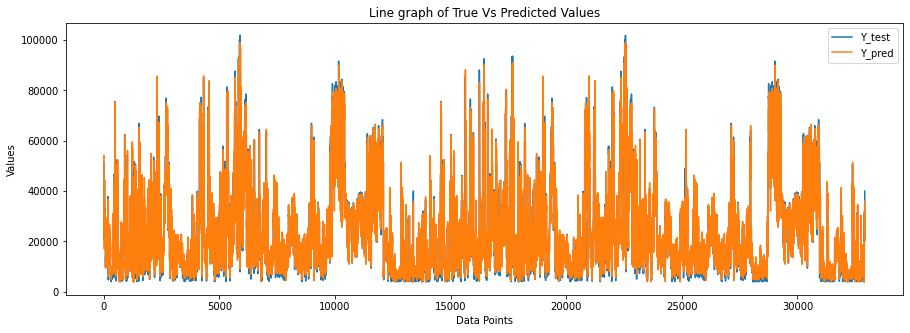

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

In [ ]:
Y_test=Y_test['DL_bitrate']

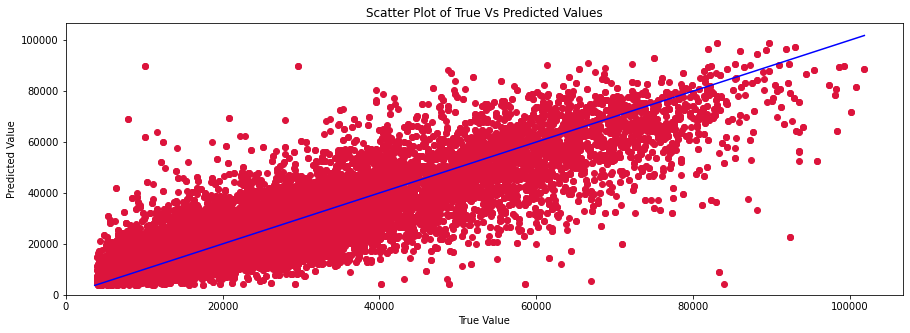

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

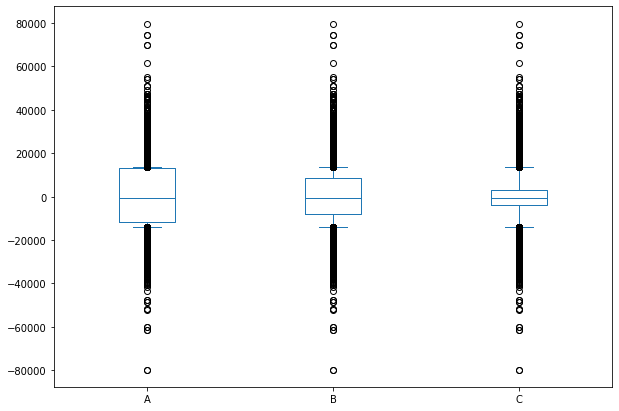

In [ ]:
a=Y_test.subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred=Y_pred[15]

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(5364.83154296875, shape=(), dtype=float64)
Decimal Representation: 5364.83154296875000000000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.4191302780547922

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.22870529871106787

# Without Throughput Split

In [ ]:
frame_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,7.0,7.0,10.0,7.0,7.0,0.0,0.0,310.0,3.0,3.0,...,7.0,7.0,10.0,10.0,0.0,0.0,14.0,7.0,7.0,1769.0
1,7.0,7.0,7.0,10.0,7.0,0.0,0.0,0.0,310.0,3.0,...,8.0,7.0,7.0,10.0,0.0,0.0,0.0,14.0,7.0,2272.0
2,7.0,7.0,7.0,7.0,10.0,0.0,0.0,0.0,0.0,310.0,...,8.0,8.0,7.0,7.0,0.0,0.0,0.0,0.0,14.0,2549.0
3,9.0,7.0,7.0,7.0,7.0,1757.0,0.0,0.0,0.0,0.0,...,10.0,8.0,8.0,7.0,68.0,0.0,0.0,0.0,0.0,2674.0
4,9.0,9.0,7.0,7.0,7.0,4216.0,1757.0,0.0,0.0,0.0,...,10.0,10.0,8.0,8.0,151.0,68.0,0.0,0.0,0.0,2393.0


In [ ]:
frame_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,12.0,11.0,12.0,11.0,11.0,46905.0,54253.0,63379.0,68557.0,68557.0,...,18.0,14.0,14.0,14.0,756.0,956.0,972.0,1026.0,1026.0,51399.0
1,10.0,12.0,11.0,12.0,11.0,52184.0,46905.0,54253.0,63379.0,68557.0,...,18.0,18.0,14.0,14.0,908.0,756.0,956.0,972.0,1026.0,49728.0
2,12.0,10.0,12.0,11.0,12.0,57262.0,52184.0,46905.0,54253.0,63379.0,...,16.0,18.0,18.0,14.0,828.0,908.0,756.0,956.0,972.0,46853.0
3,12.0,12.0,10.0,12.0,11.0,53862.0,57262.0,52184.0,46905.0,54253.0,...,16.0,16.0,18.0,18.0,894.0,828.0,908.0,756.0,956.0,43102.0
4,10.0,12.0,12.0,10.0,12.0,57407.0,53862.0,57262.0,52184.0,46905.0,...,16.0,16.0,16.0,18.0,1265.0,894.0,828.0,908.0,756.0,40899.0


## MinMax Scaler

In [ ]:
df = frame_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:15], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (215000, 15)
Validation set shape (92143, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
119035,0.421901,0.357143,0.357143,0.357143,0.369028,0.032124,0.049966,0.032639,0.033997,0.042597,0.444444,0.412698,0.412698,0.412698,0.409067
202411,0.486134,0.428571,0.500000,0.642857,0.088595,0.143374,0.164378,0.154431,0.146218,0.117001,0.587302,0.603175,0.603175,0.634921,0.629333
78450,0.614601,0.571429,0.357143,0.357143,0.439136,0.030639,0.043695,0.029217,0.019328,0.016548,0.380952,0.380952,0.539683,0.587302,0.550667
234061,0.486134,0.428571,0.642857,0.714286,0.719568,0.050805,0.025922,0.056712,0.029870,0.029870,0.523810,0.492063,0.492063,0.492063,0.487733
117970,0.357668,0.285714,0.285714,0.285714,0.439136,0.017513,0.014091,0.005716,0.022830,0.034523,0.412698,0.412698,0.476190,0.476190,0.472000


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (215000, 15, 1)
Validation set shape (92143, 15, 1)


### Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
model_high = keras.Sequential()
model_high.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model_high.add(Dense(units=256, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=384, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=128, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(Dense(1, kernel_initializer='normal', activation='linear'))
model_high.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=mae,metrics=[mae])
model_high.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 15)                0         
                                                                 
 dense_20 (Dense)            (None, 256)               4096      
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 384)               98688     
                                                                 
 dropout_16 (Dropout)        (None, 384)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               49280     
                                                                 
 dropout_17 (Dropout)        (None, 128)              

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model_high.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

6719/6719 [==============================] - 30s 4ms/step - loss: 0.0155 - mean_absolute_error: 0.0155 - val_loss: 0.0149 - val_mean_absolute_error: 0.0149
Epoch 2/500
6719/6719 [==============================] - 28s 4ms/step - loss: 0.0147 - mean_absolute_error: 0.0147 - val_loss: 0.0146 - val_mean_absolute_error: 0.0146
Epoch 3/500
6719/6719 [==============================] - 25s 4ms/step - loss: 0.0146 - mean_absolute_error: 0.0146 - val_loss: 0.0147 - val_mean_absolute_error: 0.0147
Epoch 4/500
6719/6719 [==============================] - 25s 4ms/step - loss: 0.0146 - mean_absolute_error: 0.0146 - val_loss: 0.0148 - val_mean_absolute_error: 0.0148
Epoch 5/500
6719/6719 [==============================] - 26s 4ms/step - loss: 0.0145 - mean_absolute_error: 0.0145 - val_loss: 0.0145 - val_mean_absolute_error: 0.0145
Epoch 6/500
6719/6719 [==============================] - 27s 4ms/step - loss: 0.0144 - mean_absolute_error: 0.0144 - val_loss: 0.0146 - val_mean_absolute_error: 0.0146
Epoc

In [ ]:
kt_train_pred_min_max_scaled = model_high.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = model_high.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.02766487383148123
Validation rmse: 0.02781812211636772


In [ ]:
df = frame_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.785714,0.714286,0.785714,0.714286,0.714286,0.431537,0.499140,0.583101,0.630740,0.630740,0.772727,0.772727,0.681818,0.681818,0.681818
1,0.642857,0.785714,0.714286,0.785714,0.714286,0.480105,0.431537,0.499140,0.583101,0.630740,0.727273,0.772727,0.772727,0.681818,0.681818
2,0.785714,0.642857,0.785714,0.714286,0.785714,0.526823,0.480105,0.431537,0.499140,0.583101,0.727273,0.727273,0.772727,0.772727,0.681818
3,0.785714,0.785714,0.642857,0.785714,0.714286,0.495542,0.526823,0.480105,0.431537,0.499140,0.727273,0.727273,0.727273,0.772727,0.772727
4,0.642857,0.785714,0.785714,0.642857,0.785714,0.528157,0.495542,0.526823,0.480105,0.431537,0.727273,0.727273,0.727273,0.727273,0.772727


In [ ]:
Y_test = frame_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_high.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

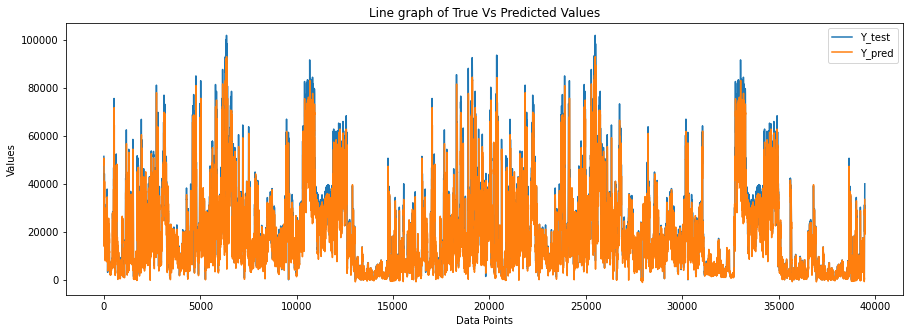

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

In [ ]:
Y_test=Y_test['DL_bitrate']

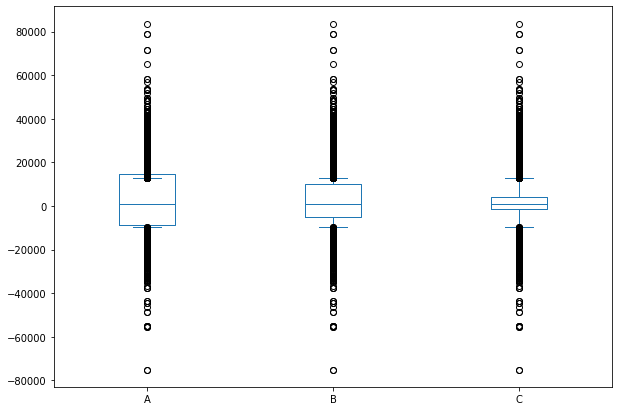

In [ ]:
a=Y_test.subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

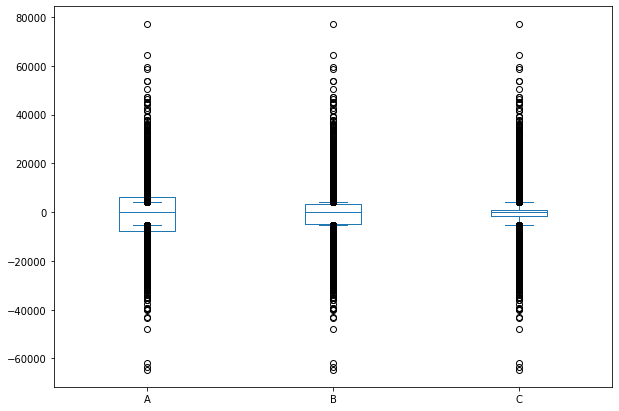

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(2676.46630859375, shape=(), dtype=float64)
Decimal Representation: 2676.46630859375000000000


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

2.8639105684498932e+16
 28639105684498932.00000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.2689981965884813

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.12610235216348925

## Testing on SPlit Throughput

## Low Throughput

In [ ]:
df = frame_low_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.214286,0.214286,0.214286,0.214286,0.214286,0.021076,0.028024,0.027147,0.020855,0.035550,0.28125,0.28125,0.322581,0.322581,0.290323
1,0.214286,0.214286,0.214286,0.214286,0.214286,0.020174,0.020489,0.028024,0.028616,0.024792,0.28125,0.28125,0.258065,0.322581,0.322581
2,0.214286,0.214286,0.214286,0.214286,0.214286,0.035675,0.019440,0.017513,0.018461,0.013172,0.21875,0.21875,0.193548,0.225806,0.225806
3,0.214286,0.214286,0.214286,0.214286,0.214286,0.016565,0.034682,0.019440,0.018461,0.021946,0.21875,0.21875,0.193548,0.193548,0.225806
4,0.285714,0.357143,0.285714,0.285714,0.214286,0.021254,0.024515,0.016291,0.019006,0.009658,0.31250,0.31250,0.129032,0.129032,0.129032


In [ ]:
Y_test = frame_low_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_high.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

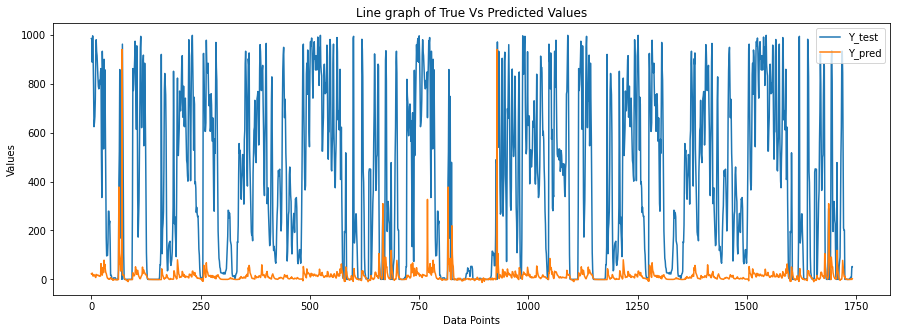

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

In [ ]:
Y_test=Y_test['DL_bitrate']

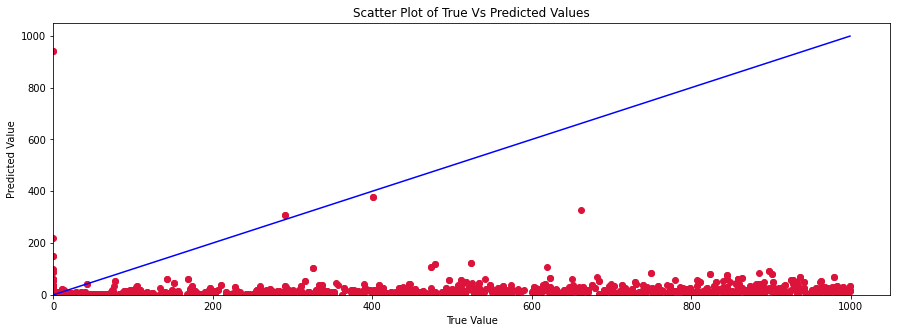

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

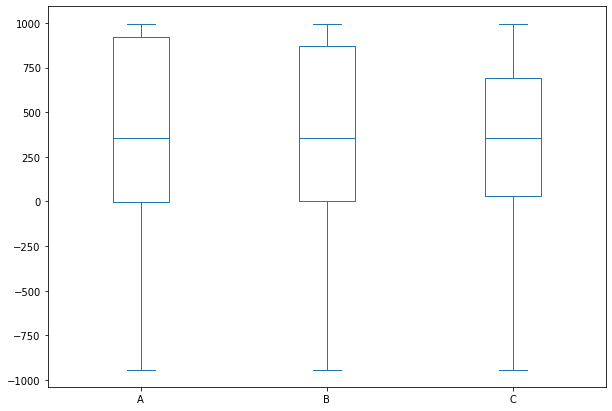

In [ ]:
a=Y_test.subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred=Y_pred[15]

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(389.47802734375, shape=(), dtype=float64)
Decimal Representation: 389.47802734375000000000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

1.007694413491185

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

1.7365070969155798

## Medium Throughput

In [ ]:
df = frame_medium_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.500000,0.357143,0.357143,0.357143,0.642857,0.618253,1.000000,0.406484,0.467536,0.707695,0.459459,0.485714,0.457143,0.457143,0.315789
1,0.285714,0.500000,0.357143,0.357143,0.357143,0.223683,0.618470,1.000000,0.404035,0.430428,0.378378,0.485714,0.485714,0.457143,0.500000
2,0.214286,0.285714,0.500000,0.357143,0.357143,0.069191,0.223761,0.618470,0.993973,0.371967,0.378378,0.400000,0.485714,0.485714,0.500000
3,0.357143,0.357143,0.285714,0.285714,0.285714,0.210476,0.203051,0.176277,0.173121,0.112016,0.243243,0.257143,0.228571,0.228571,0.368421
4,0.357143,0.357143,0.357143,0.285714,0.285714,0.130216,0.210550,0.203051,0.175215,0.159381,0.270270,0.257143,0.257143,0.228571,0.289474


In [ ]:
Y_test = frame_medium_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_high.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

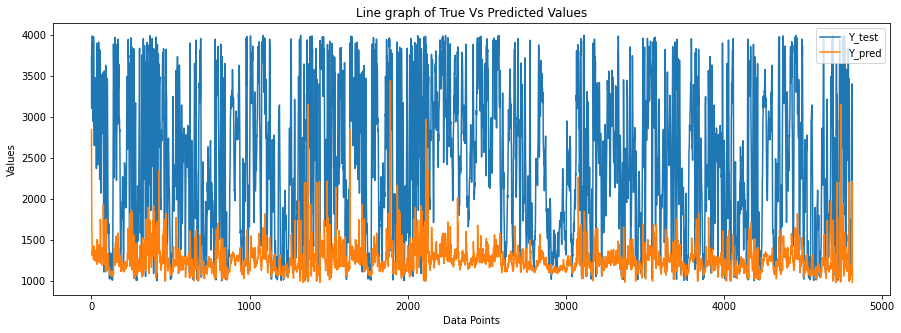

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

In [ ]:
Y_test=Y_test['DL_bitrate']

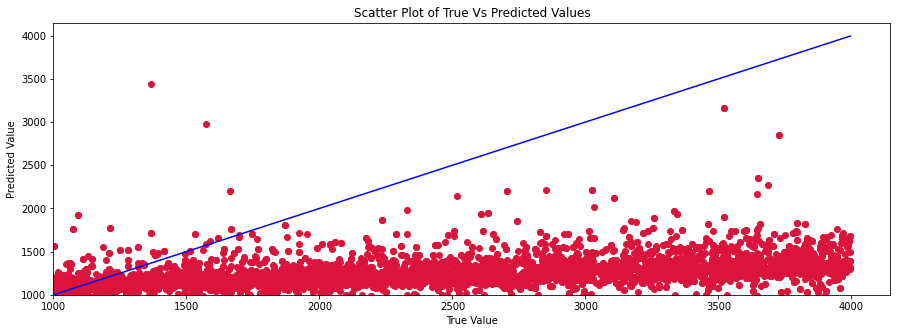

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(1000, None),ylim=(1000, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

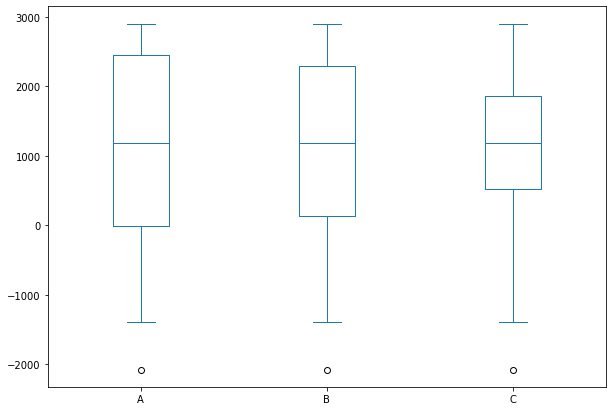

In [ ]:
a=Y_test.subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred=Y_pred[15]

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(1207.2862548828125, shape=(), dtype=float64)
Decimal Representation: 1207.28625488281250000000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

1.0105352394454055

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

1.409296577960203

## High Throughput

In [ ]:
df = frame_high_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.785714,0.714286,0.785714,0.714286,0.714286,0.431537,0.499140,0.583101,0.630740,0.630740,0.772727,0.772727,0.681818,0.681818,0.681818
1,0.642857,0.785714,0.714286,0.785714,0.714286,0.480105,0.431537,0.499140,0.583101,0.630740,0.727273,0.772727,0.772727,0.681818,0.681818
2,0.785714,0.642857,0.785714,0.714286,0.785714,0.526823,0.480105,0.431537,0.499140,0.583101,0.727273,0.727273,0.772727,0.772727,0.681818
3,0.785714,0.785714,0.642857,0.785714,0.714286,0.495542,0.526823,0.480105,0.431537,0.499140,0.727273,0.727273,0.727273,0.772727,0.772727
4,0.642857,0.785714,0.785714,0.642857,0.785714,0.528157,0.495542,0.526823,0.480105,0.431537,0.727273,0.727273,0.727273,0.727273,0.772727


In [ ]:
Y_test = frame_high_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_high.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

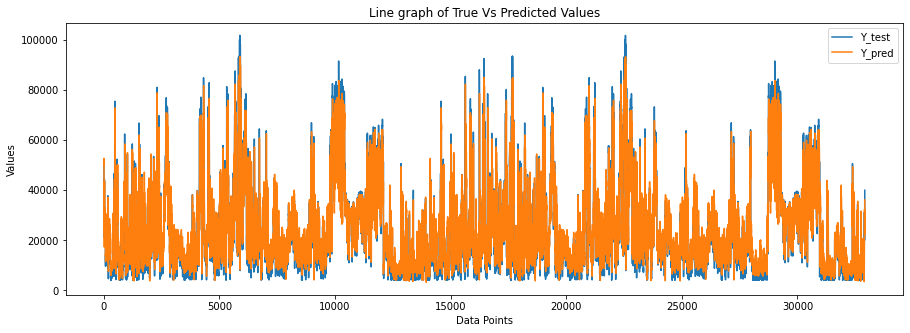

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

In [ ]:
Y_test=Y_test['DL_bitrate']

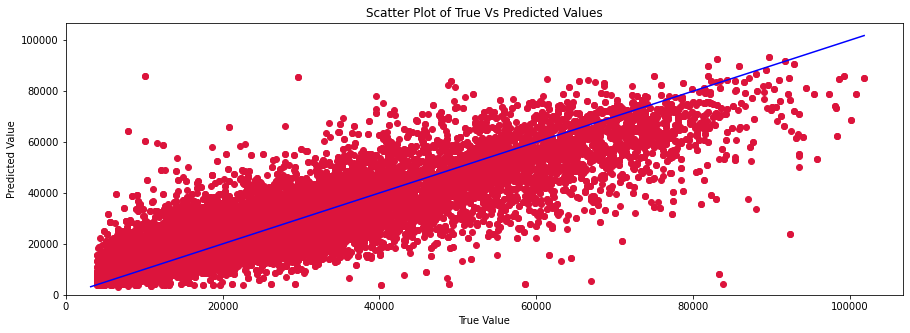

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

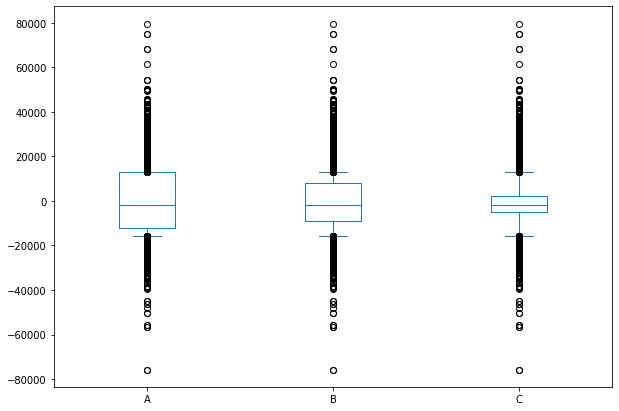

In [ ]:
a=Y_test.subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred=Y_pred[15]

In [ ]:

# calculate MAE
error = mae(Y_test, Y_pred)
  
# display
print("Mean absolute error : " + str(error))

Mean absolute error : tf.Tensor(5667.72265625, shape=(), dtype=float64)


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.48358697108191845

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.2689432162941752